In [1]:
import os
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import warnings
from PIL import Image
from shutil import rmtree
warnings.filterwarnings('ignore')

2024-06-06 23:25:41.211338: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 23:25:42.024317: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
path_original = '256X'
path_blurred = 'Zgaussowane'

# Funkcja do ładowania i przetwarzania obrazów
def load_images(path, size=(256, 256)):
    images = []
    for filename in sorted(os.listdir(path)):
        img_path = os.path.join(path, filename)
        img = load_img(img_path, target_size=size, color_mode='rgb')
        img = img_to_array(img) / 255.0  # Normalizacja obrazów do zakresu [0, 1]
        images.append(img)
    return np.array(images)

In [3]:
for sciezka in ['256X/.ipynb_checkpoints', 'Zgaussowane/.ipynb_checkpoints', 'Test_Gauss/.ipynb_checkpoints']:
    if os.path.isdir(sciezka):
        rmtree(sciezka)

In [4]:
original_images = load_images(path_original)
blurred_images = load_images(path_blurred)

print(f'Liczba załadowanych oryginalnych obrazów: {len(original_images)}')
print(f'Liczba załadowanych zblurowanych obrazów: {len(blurred_images)}')

Liczba załadowanych oryginalnych obrazów: 159
Liczba załadowanych zblurowanych obrazów: 159


In [5]:
def build_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

input_shape = (256, 256, 3)
model = build_model(input_shape)
model.summary()

2024-06-06 23:25:44.093929: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 23:25:44.542759: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 256, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 256, 256, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 335,683 (1.28 MB)

 Trainable params: 335,683 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
#def build_model(input_shape):
#    model = Sequential()
#    model.add(Input(shape=input_shape))
#    model.add(UpSampling2D((2, 2)))
#    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
#    model.add(MaxPooling2D((2, 2)))
#    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
#    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
#    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
#    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
#    model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))
#    
#    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
#    return model
#
#input_shape = (256, 256, 3)
#model = build_model(input_shape)
#model.summary()

In [7]:
from sklearn.model_selection import train_test_split

ilosc_epok = 36
# Podział danych na treningowe i walidacyjne
X_train, X_val, y_train, y_val = train_test_split(blurred_images, original_images, random_state=42)

# Trenowanie modelu
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=ilosc_epok, batch_size=8)

# Zapisywanie modelu
# model.save('deblur_cnn_model.h5')
keras.saving.save_model(model, f'deblur_cnn_model_redux{ilosc_epok}.keras')

Epoch 1/36
15/15 ━━━━━━━━━━━━━━━━━━━━ 124s 8s/step - loss: 0.0711 - val_loss: 0.0285
Epoch 2/36
15/15 ━━━━━━━━━━━━━━━━━━━━ 135s 8s/step - loss: 0.0254 - val_loss: 0.0138
Epoch 3/36
15/15 ━━━━━━━━━━━━━━━━━━━━ 120s 8s/step - loss: 0.0117 - val_loss: 0.0099
Epoch 4/36
15/15 ━━━━━━━━━━━━━━━━━━━━ 141s 8s/step - loss: 0.0084 - val_loss: 0.0088
Epoch 5/36
15/15 ━━━━━━━━━━━━━━━━━━━━ 117s 8s/step - loss: 0.0069 - val_loss: 0.0097
Epoch 6/36
15/15 ━━━━━━━━━━━━━━━━━━━━ 118s 8s/step - loss: 0.0065 - val_loss: 0.0083
Epoch 7/36
15/15 ━━━━━━━━━━━━━━━━━━━━ 114s 8s/step - loss: 0.0059 - val_loss: 0.0076
Epoch 8/36
15/15 ━━━━━━━━━━━━━━━━━━━━ 116s 8s/step - loss: 0.0061 - val_loss: 0.0063
Epoch 9/36
15/15 ━━━━━━━━━━━━━━━━━━━━ 144s 8s/step - loss: 0.0058 - val_loss: 0.0061
Epoch 10/36
15/15 ━━━━━━━━━━━━━━━━━━━━ 115s 8s/step - loss: 0.0048 - val_loss: 0.0049
Epoch 11/36
15/15 ━━━━━━━━━━━━━━━━━━━━ 143s 8s/step - loss: 0.0040 - val_loss: 0.0050
Epoch 12/36
15/15 ━━━━━━━━━━━━━━━━━━━━ 142s 8s/step - loss: 0.0

In [8]:
path_test = 'Test_Gauss/'
test_images = load_images(path_test)
X_test, y_test = train_test_split(test_images, random_state=42)

In [9]:
# model_path = 'deblur_cnn_model_redux.keras'
# keras.saving.load_model(model_path, custom_objects=None, compile=True, safe_mode=True)

In [10]:
import matplotlib.pyplot as plt

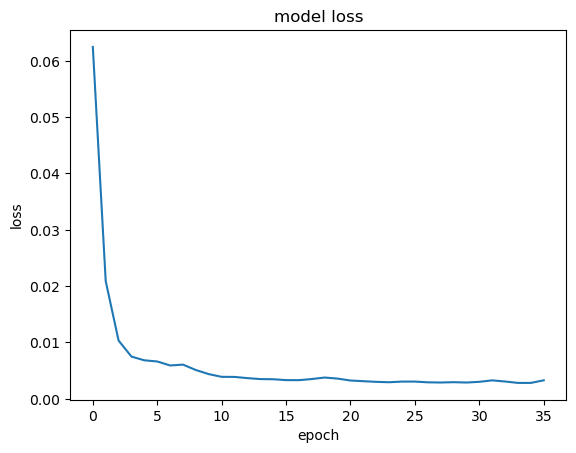

In [11]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [12]:
for i in range(5):
    restored_image = model.predict(np.expand_dims(X_val[i], axis=0))

    restored_image = restored_image[0] * 255
    restored_image = restored_image.astype('uint8')

    restored_image_pil = Image.fromarray(restored_image)
    restored_image_pil.save(f'Restored/{i}_{ilosc_epok}.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


In [16]:
for i in range(6):
    test_image = model.predict(np.expand_dims(X_test[i], axis=0))

    test_image = test_image[0] * 255
    test_image = test_image.astype('uint8')

    test_image_pil = Image.fromarray(test_image)
    test_image_pil.save(f'Restored/Test_{i}_{ilosc_epok}.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
